In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

## Load data and matched model output

In [2]:
matchpath='/home/sallen/202007/202007J-p2/ObsModel_202007Jp2f0_hplc_20150101_20151231.csv'
data=pd.read_csv(matchpath,index_col=0)
data.dropna(axis=1,how='all',inplace=True)
data['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') for ii in data['dtUTC']]
Chl_N = 1.8

In [3]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [4]:
data.keys()

Index(['dtUTC', 'Lat', 'Lon', 'Z', 'p', 'i', 'j', 'k', 'Sample_Number',
       'Diatoms-1', 'Diatoms-2', 'Prasinophytes', 'Cryptophytes',
       'Dinoflagellates', 'Haptophytes', 'Dictyochophytes', 'Raphidophytes',
       'Cyanobacteria', 'TchlA (ug/L)', 'Chlorophyll:Extracted [mg/m^3]',
       'Nitrate_plus_Nitrite [umol/L]', 'Silicate [umol/L]', 'SA', 'CT',
       'mod_nitrate', 'mod_silicon', 'mod_ammonium', 'mod_diatoms',
       'mod_ciliates', 'mod_flagellates', 'mod_vosaline', 'mod_votemper'],
      dtype='object')

In [5]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

In [6]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

In [7]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

### What do HPLC-based obs look like in terms of species composition?

In [8]:
hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')

In [9]:
cols=('darkblue','cornflowerblue','cyan','olive','limegreen','magenta','orange','firebrick','plum')

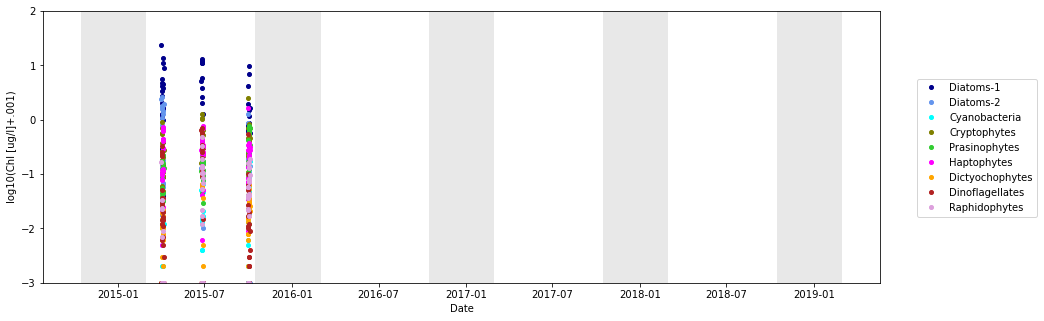

In [10]:
x=np.array([logt(data[el]) for el in hplclist]).T
fig,ax=plt.subplots(1,1,figsize=(15,5))
for i in range(0,len(hplclist)):
    ax.plot(data['dtUTC'],x[:,i],'o',color=cols[i],label=hplclist[i],ms=4)
fig.legend(loc='center right',bbox_to_anchor=[1.05,.5])
ax.set_ylim(-3,2)
ax.set_xlabel('Date')
ax.set_ylabel('log10(Chl [ug/l]+.001)')
for i in range(2015,2020):
    ax.axvspan(dt.datetime(i-1,10,15),dt.datetime(i,3,1), facecolor='lightgrey', alpha=0.5)

## Model vs Obs Plots for various model-obs groups

(0.0, 8.0)

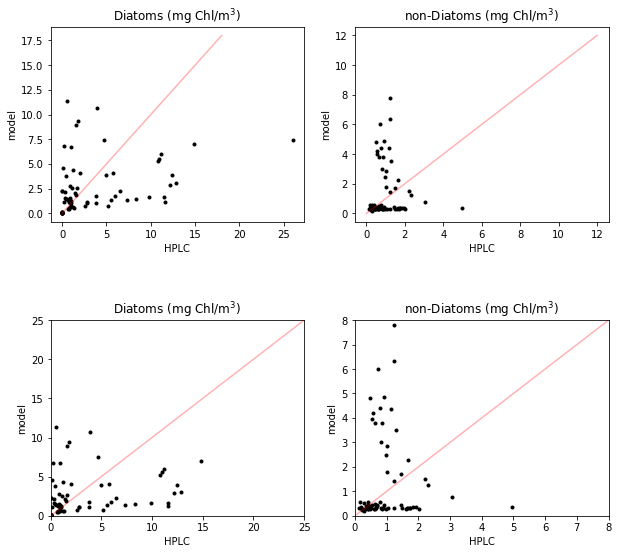

In [11]:
fig,ax=plt.subplots(2,2,figsize=(10,9))
fig.subplots_adjust(hspace=.5)
ax=ax.flatten()
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms (mg Chl/m$^3$)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,18),(0,18),'r-',alpha=.3)

ax[1].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((0,12),(0,12),'r-',alpha=.3)

ax[2].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[2].set_title('Diatoms (mg Chl/m$^3$)')
ax[2].set_xlabel('HPLC')
ax[2].set_ylabel('model')
ax[2].plot((0,25),(0,25),'r-',alpha=.3)
ax[2].set_xlim((0,25))
ax[2].set_ylim((0,25))

ax[3].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[3].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[3].set_xlabel('HPLC')
ax[3].set_ylabel('model')
ax[3].plot((0,12),(0,12),'r-',alpha=.3)
ax[3].set_xlim((0,8))
ax[3].set_ylim((0,8))

(-3.1, 2.0)

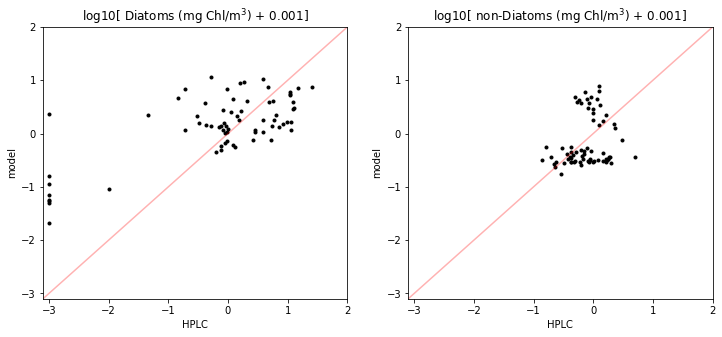

In [12]:
# log-log model vs obs
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(Chl_N*data['mod_diatoms']),'k.')
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].set_xlim(-3.1,2)
ax[0].set_ylim(-3.1,2)
ax[0].plot((-6,3),(-6,3),'r-',alpha=.3)

ax[1].plot(logt(data['other']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('log10[ non-Diatoms (mg Chl/m$^3$) + 0.001]')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((-6,3),(-6,3),'r-',alpha=.3)
ax[1].set_xlim(-3.1,2)
ax[1].set_ylim(-3.1,2)

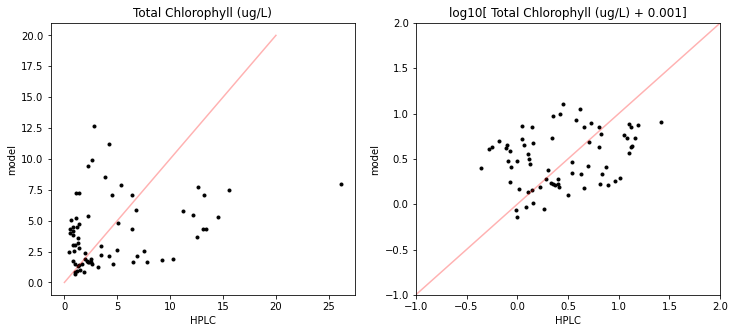

In [13]:
# total chlorophyll comparisons

fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(data['TchlA (ug/L)'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
ax[0].set_title('Total Chlorophyll (ug/L)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,20),(0,20),'r-',alpha=.3)

ax[1].plot(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),'k.')
ax[1].set_title('log10[ Total Chlorophyll (ug/L) + 0.001]')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((-6,5),(-6,5),'r-',alpha=.3)
ax[1].set_xlim(-1,2)
ax[1].set_ylim(-1,2);

### By time of year

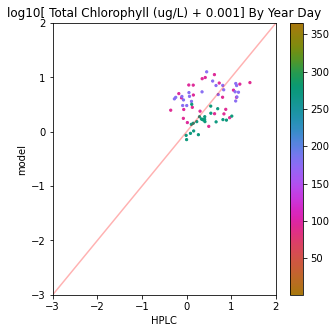

In [14]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
          c=data['yd'],s=5,cmap=cmocean.cm.phase,vmin=1,vmax=365)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-3,2)
ax.set_ylim(-3,2);
fig.colorbar(m)

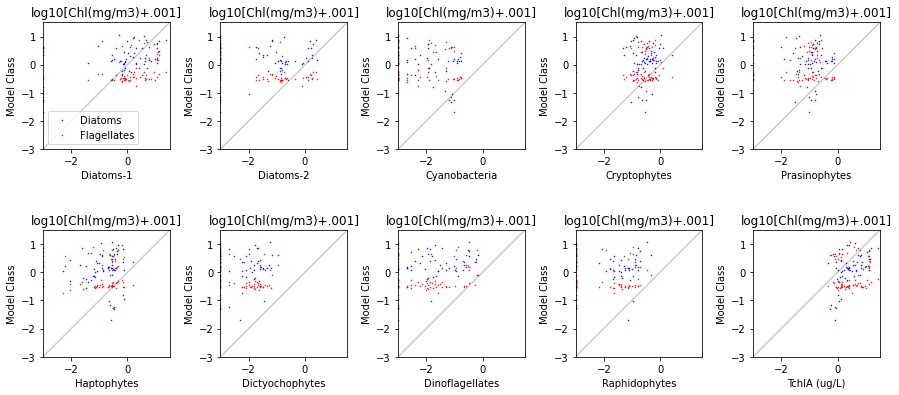

In [15]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','TchlA (ug/L)')

mvar1=Chl_N*data['mod_diatoms']
mvar2=Chl_N*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',ms=1,color='blue',label='Diatoms')
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',ms=1,color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


(-3.0, 1.5)

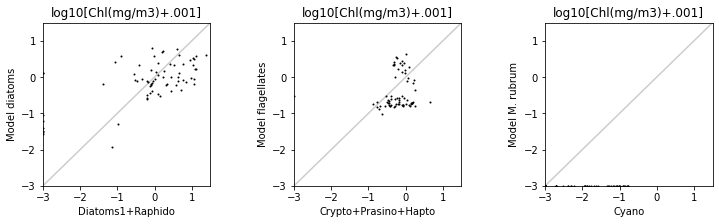

In [16]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.5)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']),logt(data['mod_diatoms']),'k.',ms=2)
ax[0].set_ylabel('Model diatoms')
ax[0].set_xlabel('Diatoms1+Raphido')
ax[0].set_title('log10[Chl(mg/m3)+.001]')
ax[0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0].set_xlim((-3,1.5))
ax[0].set_ylim((-3,1.5))

ax[1].plot(logt(data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']),logt(data['mod_flagellates']),'k.',ms=2)
ax[1].set_ylabel('Model flagellates')
ax[1].set_xlabel('Crypto+Prasino+Hapto')
ax[1].set_title('log10[Chl(mg/m3)+.001]')
ax[1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1].set_xlim((-3,1.5))
ax[1].set_ylim((-3,1.5))


ax[2].plot(logt(data['Cyanobacteria']),logt(data['mod_ciliates']),'k.',ms=2)
ax[2].set_ylabel('Model M. rubrum')
ax[2].set_xlabel('Cyano')
ax[2].set_title('log10[Chl(mg/m3)+.001]')
ax[2].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2].set_xlim((-3,1.5))
ax[2].set_ylim((-3,1.5))

### Correlation Coefficient Matrix

In [17]:
data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CPH']=data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
dfVars=data.loc[:,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]
dfVars.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.455664,-0.273233,-0.000481,-0.117818,-0.209044,-0.161622,0.257173,0.062007,0.993594,-0.123687,0.983388,0.319445,0.005440,-0.034357,0.318572
Diatoms-2,0.455664,1.000000,-0.231687,0.033504,-0.106544,-0.337970,-0.133496,0.065128,-0.090308,0.553338,-0.153835,0.531183,0.118697,-0.273549,0.154836,-0.061527
Cyanobacteria,-0.273233,-0.231687,1.000000,0.102901,0.729832,0.041623,0.330922,-0.231851,0.227147,-0.285090,0.302561,-0.238852,-0.339964,0.074626,-0.098320,-0.286537
Cryptophytes,-0.000481,0.033504,0.102901,1.000000,0.406297,0.428978,0.223758,0.603021,0.430516,0.003803,0.897810,0.147399,0.017129,-0.008234,-0.041325,0.011516
Prasinophytes,-0.117818,-0.106544,0.729832,0.406297,1.000000,0.069544,0.429987,0.030620,0.478814,-0.123773,0.577393,-0.031923,-0.143111,-0.101841,-0.083499,-0.207614
Haptophytes,-0.209044,-0.337970,0.041623,0.428978,0.069544,1.000000,-0.111318,0.206096,-0.058742,-0.238518,0.693476,-0.144091,0.107697,0.017478,-0.123440,0.117616
Dictyochophytes,-0.161622,-0.133496,0.330922,0.223758,0.429987,-0.111318,1.000000,0.127081,0.564322,-0.168185,0.218484,-0.119214,0.095122,-0.222130,-0.045460,-0.051208
Dinoflagellates,0.257173,0.065128,-0.231851,0.603021,0.030620,0.206096,0.127081,1.000000,0.412246,0.248917,0.453637,0.344585,0.126550,0.168264,-0.023961,0.234644
Raphidophytes,0.062007,-0.090308,0.227147,0.430516,0.478814,-0.058742,0.564322,0.412246,1.000000,0.046558,0.378243,0.129749,0.162793,-0.027085,-0.004607,0.142856
DD,0.993594,0.553338,-0.285090,0.003803,-0.123773,-0.238518,-0.168185,0.248917,0.046558,1.000000,-0.135269,0.987637,0.313988,-0.029637,-0.012493,0.290292


### New groups Model-Obs Comparison:

Text(0.5, 0.98, '/home/sallen/202007/202007J-p2/ObsModel_202007Jp2f0_hplc_20150101_20151231.csv 2015')

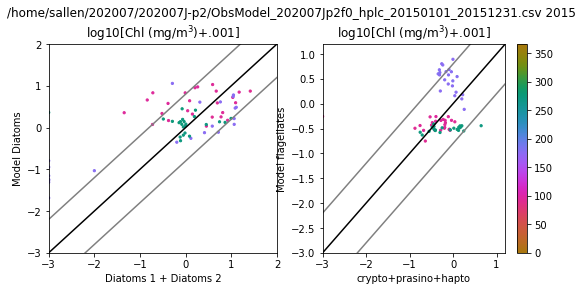

In [36]:
thresh=.8
msize=5
fig,ax=plt.subplots(1,2,figsize=(9,4),gridspec_kw={'top':.85})
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CPH']),logt(data['mod_flagellates_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
#plt.tight_layout()
fig.colorbar(m,ax=ax[1])
fig.suptitle(matchpath + ' '+ str(data['Year'][0]))

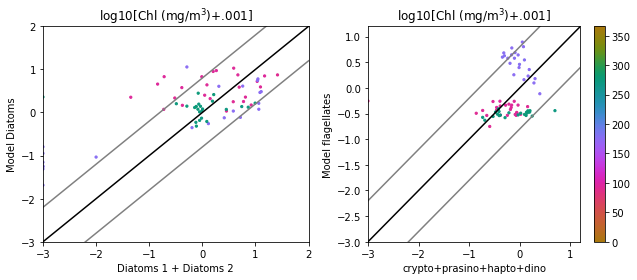

In [19]:
thresh=.8
msize=5
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CPH']+data['Dinoflagellates']),logt(data['mod_flagellates_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto+dino')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('New')

May-Aug


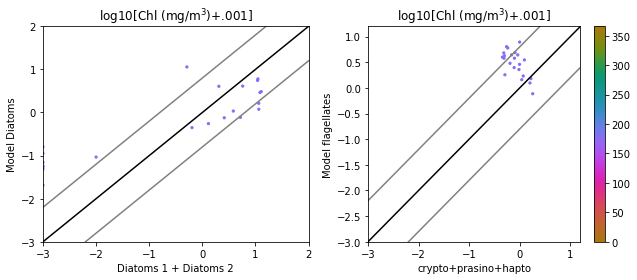

In [20]:
thresh=.8
msize=5
data2=data.loc[(data['yd']>yd(dt.datetime(2015,5,1)))&(data['yd']<yd(dt.datetime(2015,9,1)))]
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data2['DD']),logt(data2['mod_diatoms_chl']),
          c=data2['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data2['CPH']),logt(data2['mod_flagellates_chl']),
          c=data2['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('New')
print('May-Aug')

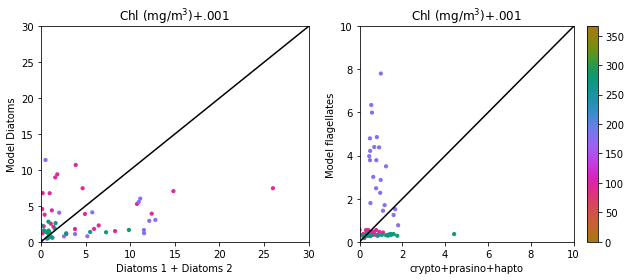

In [21]:
thresh=.8
msize=10
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(data['DD'],data['mod_diatoms_chl'],
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(data['CPH'],data['mod_flagellates_chl'],
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,10)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('Chl (mg/m$^3$)+.001')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('Chl (mg/m$^3$)+.001')
ax[0].plot((0,30),(0,30),'k-')
ax[1].plot((0,10),(0,10),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('new')

### Linear fits to deduced groupings

In [22]:
ii=(data['DD']>=0)&(data['mod_diatoms_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(data.loc[ii]['DD'],
                                                              data.loc[ii]['mod_diatoms_chl'])

In [23]:
slope, intercept, r_value*r_value

(0.17302830503922942, 2.039728339128747, 0.09858869957372234)

In [24]:
ii=(data['CPH']>=0)&(data['mod_flagellates_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(data.loc[ii]['CPH'],
                                                              data.loc[ii]['mod_flagellates_chl'])

In [25]:
slope, intercept, r_value*r_value

(-0.08233916640074514, 1.408000441212325, 0.0008331297759719042)

In [26]:
ii=(data['DD']>=0)&(data['mod_diatoms_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(logt(data.loc[ii]['DD']),
                                                              logt(data.loc[ii]['mod_diatoms_chl']))

In [27]:
slope, intercept, r_value*r_value

(0.35576350129990014, 0.19900679013912173, 0.5161959793932722)

### Check for spatial patterns in over/under-estimation

Diatoms/DD


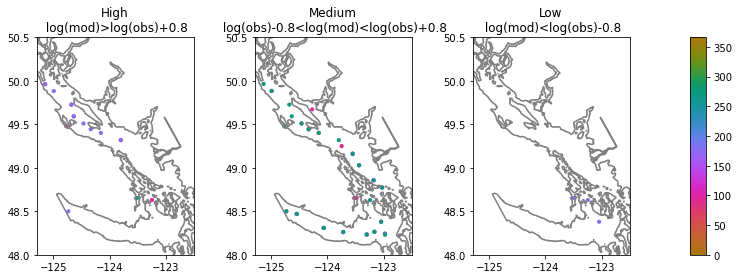

In [28]:
print('Diatoms/DD')
fig,ax=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5},)
for iax in ax[0:3]:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
ihi=logt(data['mod_diatoms_chl'])>(logt(data['DD'])+thresh)
ilo=logt(data['mod_diatoms_chl'])<(logt(data['DD'])-thresh)
idata=data.loc[(data.DD>=0)&ihi]
ax[0].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=data.loc[(data.DD>=0)&(~ihi)&(~ilo)]
ax[1].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh))
idata=data.loc[(data.DD>=0)&ilo]
m=ax[2].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3]);

Flagellates/CPH


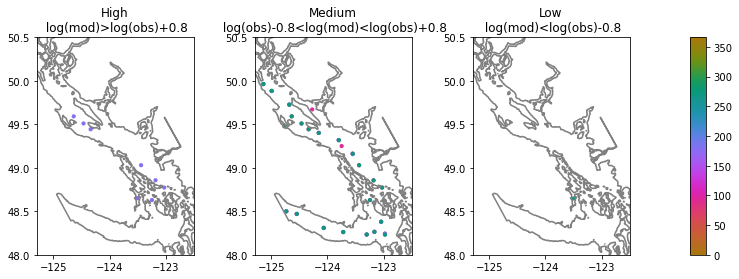

In [29]:
print('Flagellates/CPH')
fig,ax=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5},)
for iax in ax[0:3]:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
ihi=logt(data['mod_flagellates_chl'])>(logt(data['CPH'])+thresh)
ilo=logt(data['mod_flagellates_chl'])<(logt(data['CPH'])-thresh)
idata=data.loc[(data.CPH>=0)&ihi]
ax[0].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=data.loc[(data.CPH>=0)&(~ihi)&(~ilo)]
ax[1].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh))
idata=data.loc[(data.CPH>=0)&ilo]
m=ax[2].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3]);

### Species composition (fractional) by time of year

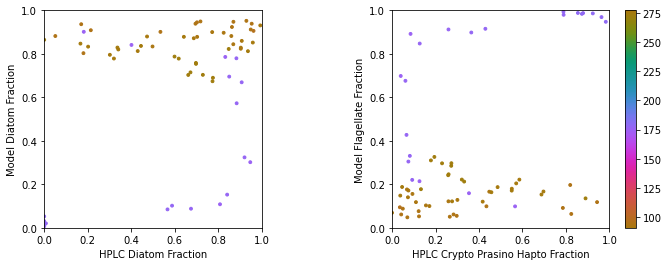

In [30]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
diatFracMod=data['mod_diatoms']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
diatFracObs=data['DD']/data['TchlA (ug/L)']
m=ax[0].scatter(diatFracObs,diatFracMod,
          c=data['yd'],s=8,cmap=cmocean.cm.phase)
ax[0].set_xlabel('HPLC Diatom Fraction')
ax[0].set_ylabel('Model Diatom Fraction')
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
flFracMod=data['mod_flagellates']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
CPHFracObs=data['CPH']/data['TchlA (ug/L)']
m=ax[1].scatter(CPHFracObs,flFracMod,
          c=data['yd'],s=8,cmap=cmocean.cm.phase)
ax[1].set_xlabel('HPLC Crypto Prasino Hapto Fraction')
ax[1].set_ylabel('Model Flagellate Fraction')
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

fig.colorbar(m)

In [31]:
#Reminder:
np.random.seed(42)
df = pd.DataFrame(np.random.randn(1000, 4),columns=['a', 'b', 'c','d'])
df['a+b+c']=.2*df['a']+.3*df['b']+.45*df['c']

In [32]:
df.cov()

,a,b,c,d,a+b+c
a,0.929140,0.007946,-0.037053,-0.022301,0.171538
b,0.007946,1.023910,-0.032939,0.004689,0.293940
c,-0.037053,-0.032939,1.012188,0.034186,0.438192
d,-0.022301,0.004689,0.034186,1.013977,0.012330
a+b+c,0.171538,0.293940,0.438192,0.012330,0.319676


In [33]:
df.corr()

,a,b,c,d,a+b+c
a,1.000000,0.008146,-0.038208,-0.022976,0.314749
b,0.008146,1.000000,-0.032355,0.004602,0.513774
c,-0.038208,-0.032355,1.000000,0.033745,0.770334
d,-0.022976,0.004602,0.033745,1.000000,0.021657
a+b+c,0.314749,0.513774,0.770334,0.021657,1.000000


In [34]:
A=np.vstack([df['a'],df['b'],df['c'],df['d'],np.ones(np.shape(df['a']))]).T
b=df['a+b+c']
m=np.linalg.lstsq(A,b,rcond=None)[0]
print(m)

[ 2.00000000e-01  3.00000000e-01  4.50000000e-01  6.93889390e-17
 -1.31838984e-16]
